## Brain Tumor Classification

A brain tumor like the name implies is an abnormal condition that affects the brain cells. Since the skull that encloses the brain is very rigid, it poses a threat for any growth to happen in such a restricted area. Brain tumors can be cancerous (malignant) or noncancerous (benign), and when they grow, they can cause the pressure inside the skull to increase. This could lead to brain damage, and be life-threatening.
```
Dataset Link:
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data
```

In [1]:
# import neccessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import cv2
from tqdm import tqdm
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from glob import glob

## Create Dataframe for train and test images
- Create placeholders (`train_path`/`test_path`) for train and test paths
- Create a function to load the train and test images with its appropriate labels into dataframes
- `train_data_df` and `test_data_df` dataframes for further analysis
- Visualisation to see class label distribution of the train_data_df 

In [2]:
# Train and test image directories
train_path = "../DATASET/Training/"
test_path = "../DATASET/Testing/"

In [3]:
# A function to extract images and labels into a dataframe
def load_images_and_labels(base_path):
    images = []
    labels = []

    # Categories of the different type of tumor
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for category in categories:
        path = os.path.join(base_path, category)
        files = glob(os.path.join(path, "*"))
        
        count = 0
        for file in tqdm(files, desc=f"Loading {category} images"):
            img_array = cv2.imread(file)
            if img_array is not None:
                images.append(img_array)
                labels.append(category)
                count += 1
        
        print(f"Loaded {count} images for category '{category}'")
    
    data=pd.DataFrame({'image': images,'label': labels})
    return data

In [4]:
# Invoke function to create train_data_df
train_data_df = load_images_and_labels(train_path)

Loading glioma images: 100%|██████████████████████████████████████████████████████| 1321/1321 [00:03<00:00, 347.57it/s]


Loaded 1321 images for category 'glioma'


Loading meningioma images: 100%|██████████████████████████████████████████████████| 1339/1339 [00:04<00:00, 330.20it/s]


Loaded 1339 images for category 'meningioma'


Loading notumor images: 100%|█████████████████████████████████████████████████████| 1595/1595 [00:03<00:00, 406.43it/s]


Loaded 1595 images for category 'notumor'


Loading pituitary images: 100%|███████████████████████████████████████████████████| 1457/1457 [00:09<00:00, 150.25it/s]

Loaded 1457 images for category 'pituitary'


In [5]:
# Check train_data_df information
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5712 non-null   object
 1   label   5712 non-null   object
dtypes: object(2)
memory usage: 89.4+ KB


In [6]:
# Invoke function to create test_data_df
test_data_df = load_images_and_labels(test_path)

Loading glioma images: 100%|████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 212.49it/s]


Loaded 300 images for category 'glioma'


Loading meningioma images: 100%|████████████████████████████████████████████████████| 306/306 [00:01<00:00, 262.01it/s]


Loaded 306 images for category 'meningioma'


Loading notumor images: 100%|███████████████████████████████████████████████████████| 405/405 [00:00<00:00, 420.15it/s]


Loaded 405 images for category 'notumor'


Loading pituitary images: 100%|██████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.63it/s]

Loaded 300 images for category 'pituitary'


In [7]:
# Check test_data_df information
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1311 non-null   object
 1   label   1311 non-null   object
dtypes: object(2)
memory usage: 20.6+ KB


In [8]:
# View the shape of train and test dataset
print(f"Train dataset shape: {train_data_df.shape}")
print(f"Test dataset shape: {test_data_df.shape}")

Train dataset shape: (5712, 2)
Test dataset shape: (1311, 2)


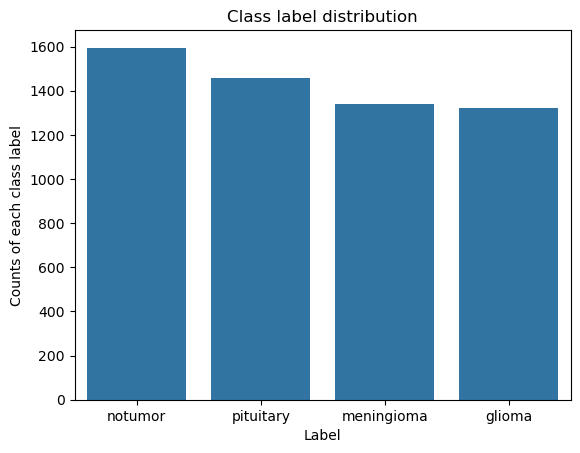

In [9]:
# Visualise the barplot (count) of each class label
train_label_distribution = train_data_df["label"].value_counts()

# A quick bar plot to see the distribution
label_class_plot = sns.barplot(x=train_label_distribution.index, y=train_label_distribution.values)
# label the axis
plt.title("Class label distribution")
plt.xlabel("Label")
plt.ylabel("Counts of each class label")

# Save plot to file
plt.savefig("../outputs/br_tumor_class_distr.png", dpi=300, bbox_inches='tight')

# Show Plot
plt.show()

## Visualisations of sample images of brain tumor types
- Create a function to visualise the different brain tumor category from train dataset images
- Invoke function to display some images of each category

In [10]:
def show_images_by_label(df, label_names, num_images=5):
    """
    Display a grid of images for each label in label_names.
    
    Parameters:
    - df: DataFrame with columns 'image' and 'label'
    - label_names: list of labels to display (e.g., ['glioma', 'meningioma', 'notumor', 'pituitary'])
    - num_images: number of images to show per label
    """
    num_labels = len(label_names)
    plt.figure(figsize=(num_images * 3, num_labels * 3))

    for row_idx, label in enumerate(label_names):
        filtered_df = df[df["label"] == label].head(num_images)
        for col_idx, img in enumerate(filtered_df["image"]):
            plt_idx = row_idx * num_images + col_idx + 1
            plt.subplot(num_labels, num_images, plt_idx)
            plt.imshow(img)
            plt.title(f"{label} #{col_idx + 1}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

### Display first 5 images for ['glioma', 'meningioma', 'notumor', 'pituitary']

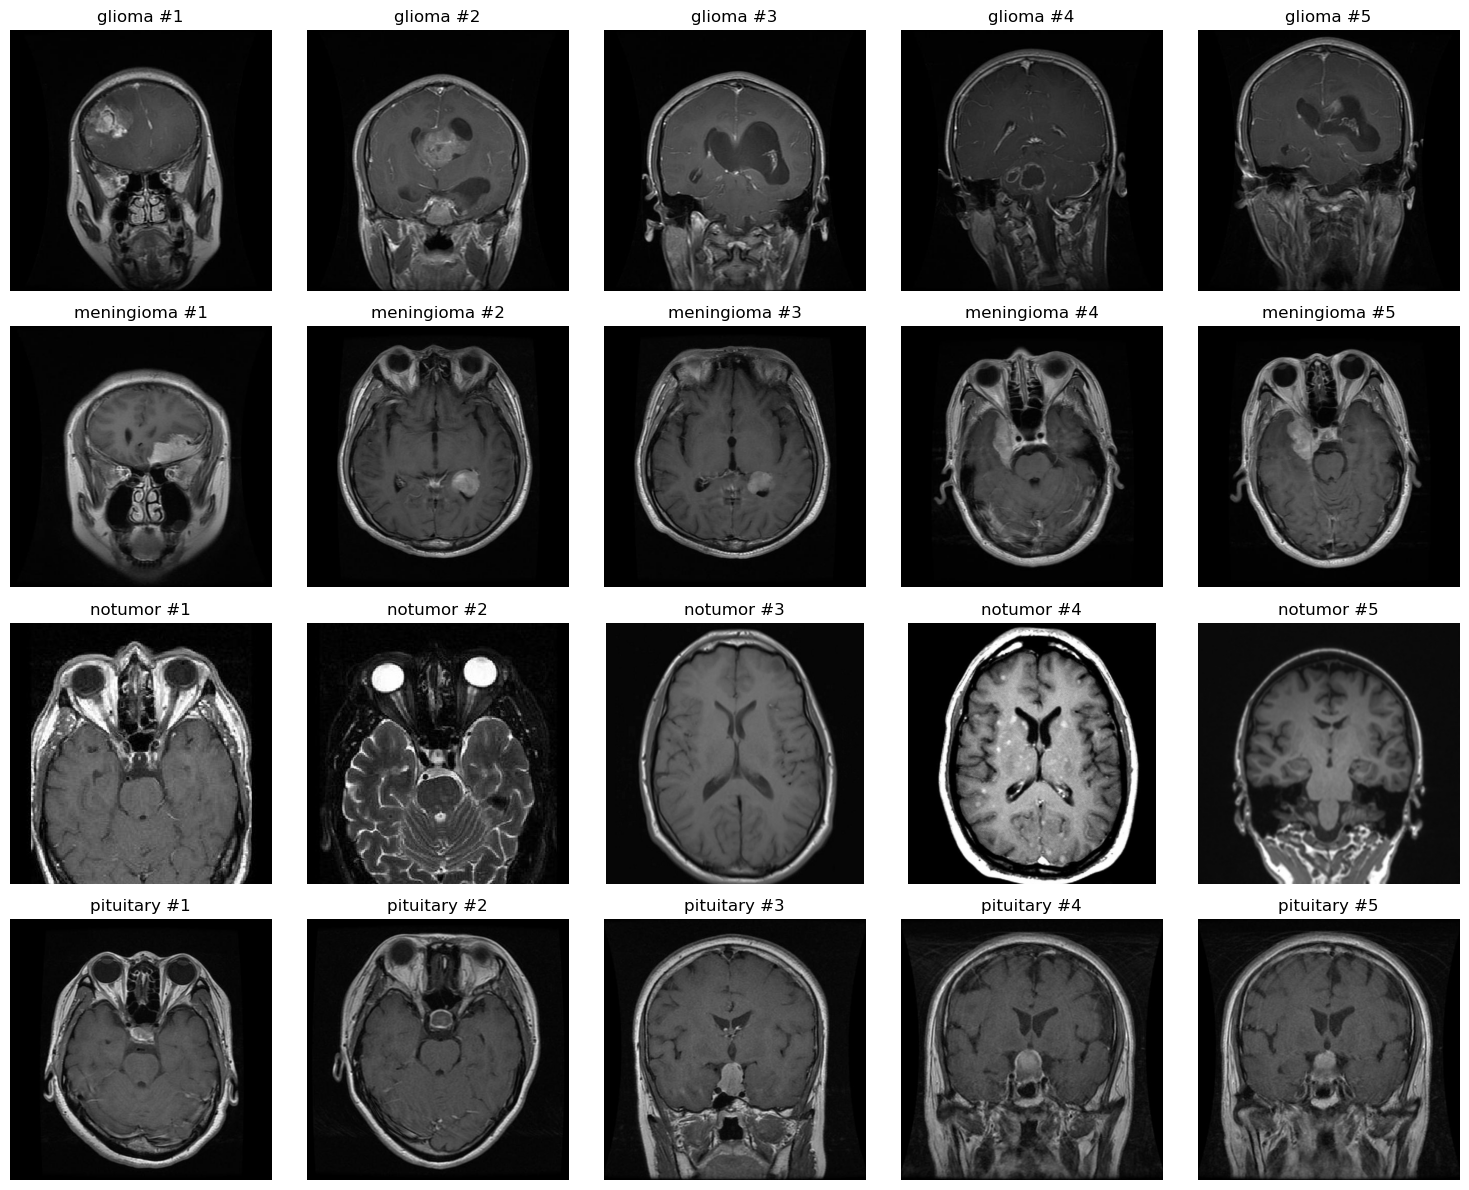

In [11]:
# List of brain tumor types
tumor_types = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Call the function to display 5 images per type
show_images_by_label(train_data_df, label_names=tumor_types, num_images=5)

## Data Augmentation
The reason for image transformations is because images can vary in:
`Lighting, Angle, Background clutter, Object position`

NB: These augmentations help your CNN generalize better and avoid overfitting to specific image setups.

In [12]:
# Rescale pixel values and add augmentation
# Use for train path
train_val_datagen = ImageDataGenerator(
    rescale=1./255,    # Normalize pixel values
    rotation_range=20, # Randomly rotate images up to 20 degrees
    width_shift_range=0.1, # Randomly shift images horizontally up to 10% of the width
    height_shift_range=0.1, # Randomly shift images vertically up to 10% of the height
    horizontal_flip=True, # Randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
    shear_range=0.10, # crops part of the image
    zoom_range=0.10, # Zooms the image by 10%
    validation_split=0.2 # Keeps 20% for validation
)

# Use for test path
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Apply rescaled pixel values and augmentation to train path (train/val)
train_generator = train_val_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_val_datagen.flow_from_directory(
    train_path, # 20% extracted from train path as validation subset
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [14]:
# Apply rescaled pixel values to test path
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # Keep the order of the labels
)

Found 1311 images belonging to 4 classes.


## Image Classification with a CNN Model

In [15]:
# Build the CNN model
model = Sequential()
model.add(Input(shape=(150, 150, 3)))

# Number of filters increases further deep into the network
# Add the first Convolutional layer, with 32 filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a second convolutional layer, with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a third convolutional layer, with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# The Flatten() layer takes 3D tensor (height, width, channels) and reshapes it into a 1D array
# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for the 4 classes of brain tumor
model.add(Dense(len(tumor_types), activation='softmax'))

# Print a summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,402,308 (20.61 MB)

 Trainable params: 5,402,308 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compile with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Train the CNN model

In [17]:
# Implement Early Stop and Model Check point
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min'),
             ModelCheckpoint('../models/br_tumor_model.keras', save_best_only=True, monitor='val_loss', mode='min')]

In [18]:
# Train the model with early stop
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.4358 - loss: 1.2031 - val_accuracy: 0.6713 - val_loss: 0.8830
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 131s 917ms/step - accuracy: 0.7099 - loss: 0.7076 - val_accuracy: 0.7099 - val_loss: 0.7987
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 131s 912ms/step - accuracy: 0.7755 - loss: 0.5846 - val_accuracy: 0.7187 - val_loss: 0.8109
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 127s 890ms/step - accuracy: 0.7964 - loss: 0.5336 - val_accuracy: 0.7625 - val_loss: 0.6869
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 127s 885ms/step - accuracy: 0.7851 - loss: 0.5200 - val_accuracy: 0.7388 - val_loss: 0.6863
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 126s 881ms/step - accuracy: 0.8144 - loss: 0.4825 - val_accuracy: 0.7581 - val_loss: 0.7086
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 126s 878ms/step - accuracy: 0.8359 - loss: 0.4423 - val_accuracy: 0.7467 - val_loss: 0.7041
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 33927s 239s/step - accuracy: 0.8240 - l

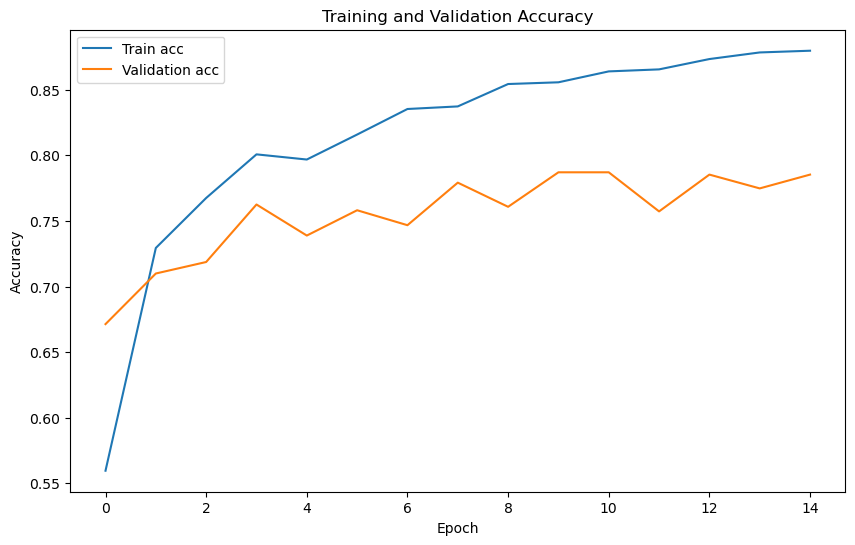

In [19]:
# Plot training and validation accuracy curves
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")

# Add title and labels
plt.title(f"Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Save plot to file
plt.savefig("../outputs/br_model_hist_accuracy.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

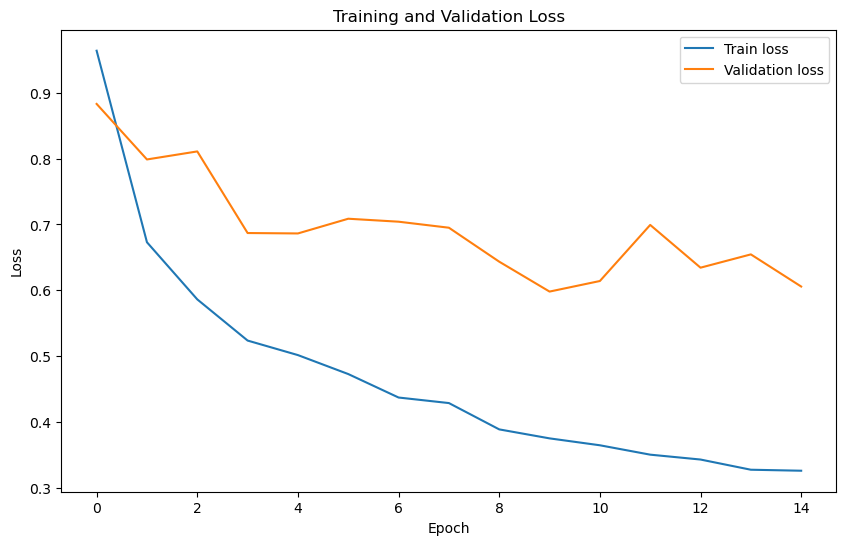

In [20]:
# Plot training and validation loss curves
plt.figure(figsize=[10,6])
plt.plot(history.history["loss"], label = "Train loss")
plt.plot(history.history["val_loss"], label = "Validation loss")

# Add title and labels
plt.title(f"Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Save plot to file
plt.savefig("../outputs/br_model_hist_loss.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [21]:
# Load the best saved model
model = load_model('../models/br_tumor_model.keras')

# Display the model architecture again to verify loading
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,206,926 (61.82 MB)

 Trainable params: 5,402,308 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,804,618 (41.22 MB)

In [22]:
# Test Loss and Accuracy
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.6614 - loss: 0.9193
Test Loss: 0.6329
Test Accuracy: 0.7727


In [23]:
# Get predictions: each row is a probability distribution across 4 classes
pred_probs = model.predict(test_generator)  # shape: (num_samples, 4)

# Convert probabilities to predicted class indices (0 to 3)
pred_labels = np.argmax(pred_probs, axis=1)  # shape: (num_samples,)

# Get actual class labels from test generator
true_labels = test_generator.classes  # shape: (num_samples,)

# Get class label names (to map indices to tumor types)
class_labels = list(test_generator.class_indices.keys())

# Print sample predictions
print("Actual Labels:", [class_labels[i] for i in true_labels[:5]])
print("Predicted Labels:", [class_labels[i] for i in pred_labels[:5]])


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step
Actual Labels: ['glioma', 'glioma', 'glioma', 'glioma', 'glioma']
Predicted Labels: ['notumor', 'glioma', 'glioma', 'meningioma', 'glioma']


## Classification Report and Confusion Matrix
- Analyse model performance by its classification report and how it classifies labels

In [24]:
# Print classification report
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

      glioma       0.90      0.63      0.75       300
  meningioma       0.64      0.49      0.55       306
     notumor       0.71      1.00      0.83       405
   pituitary       0.91      0.90      0.91       300

    accuracy                           0.77      1311
   macro avg       0.79      0.75      0.76      1311
weighted avg       0.78      0.77      0.76      1311



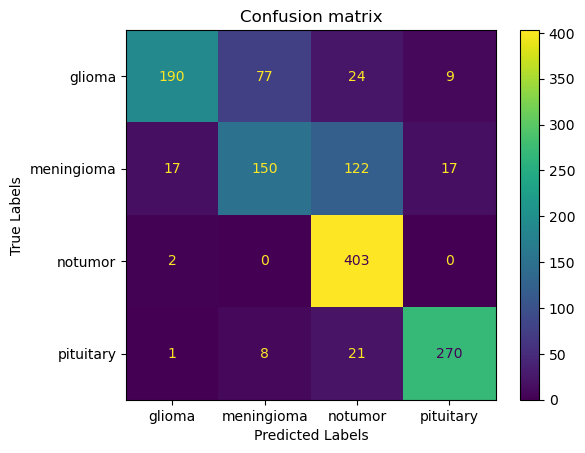

In [25]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()

# Add title and labels
plt.title("Confusion matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save plot to file
plt.savefig("../outputs/br_tumor_conf_matrix.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

## Visualisation of test images versus predictions
- Randomly select some test images for comparison with predicted labels

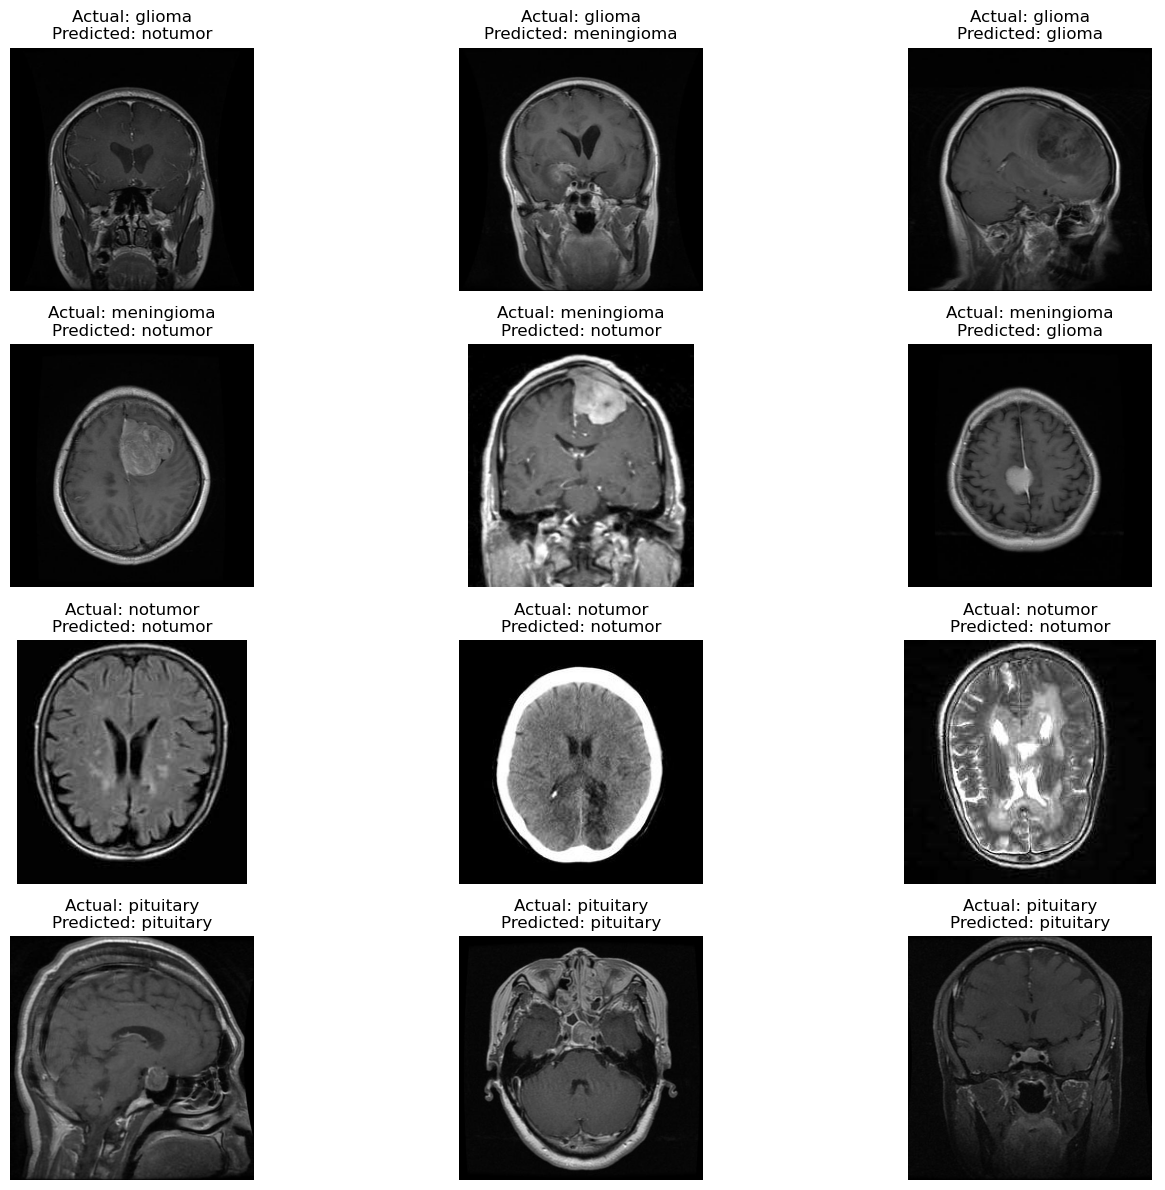

In [26]:
# Reuse already defined variables from earlier 
# (tumor_types, class_labels, true_labels, pred_labels)
# Get image paths and true/predicted labels
test_image_paths = test_generator.filepaths

# Create a figure sized for 4 rows × 3 columns
plt.figure(figsize=(15, 12))

plot_index = 1  # Track subplot position

# Loop through each tumor type
for tumor_type in tumor_types:
    # Get the class index for this tumor type
    class_idx = test_generator.class_indices[tumor_type]

    # Find all indices in the test set with this actual label
    matching_indices = np.where(true_labels == class_idx)[0]

    # Randomly select 3 of them
    selected_indices = np.random.choice(matching_indices, 3, replace=False)

    # Plot each selected image
    for idx in selected_indices:
        img = cv2.imread(test_image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        actual_label = class_labels[true_labels[idx]]
        predicted_label = class_labels[pred_labels[idx]]

        plt.subplot(4, 3, plot_index)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=12)
        plot_index += 1

plt.tight_layout()

# Save anf show the plot
plt.savefig("../outputs/test_vs_pred_br_tumor.png", dpi=300, bbox_inches='tight')
plt.show()
